<a href="https://colab.research.google.com/github/roulupen/EVAAssignments/blob/master/Assignment6/Assignment6_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

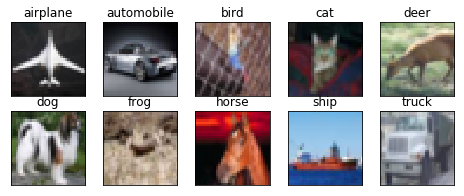

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [7]:
from keras.layers import Input, Conv2D, SeparableConv2D, DepthwiseConv2D, AveragePooling2D, Concatenate, BatchNormalization, MaxPooling2D
from keras import regularizers
from keras.models import Model
from keras.layers.merge import concatenate

model_input = Input(shape=(32, 32, 3))

#block1
x1 = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001))(model_input)
x1 = BatchNormalization()(x1) #32
x1 = SeparableConv2D(64, (3, 3), activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.001))(x1)
x1 = BatchNormalization()(x1) #32

x1 = MaxPooling2D((2,2))(x1) # 16
x1 = Dropout(0.5)(x1)

# Grouped Conv block (3,3) & (5,5)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x1)
x2 = BatchNormalization()(x2) #16

x3 = Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x1)
x3 = BatchNormalization()(x3) #16

x4 = concatenate([x2,x3])

x4 = MaxPooling2D((2,2))(x4) # 8
x4 = Dropout(0.5)(x4)


# Grouped Conv block Conv2d(3,3) dilation rate (1,1) & Conv2d(3,3) with dilation rate (2,2)
x5 = Conv2D(256, (3, 3), dilation_rate=(1, 1), activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.001))(x4)
x5 = BatchNormalization()(x5) # 8

x6 = Conv2D(256, (3, 3), dilation_rate=(2, 2), activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.001))(x4)
x6 = BatchNormalization()(x6) # 8

x7 = concatenate([x5,x6])

x8 = DepthwiseConv2D((3, 3), activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.001))(x7)
x8 = BatchNormalization()(x8) # 8

x8 = MaxPooling2D((2,2))(x8) # 6
x8 = Dropout(0.5)(x8)

x8 = Conv2D(10, (1, 1), activation='relu')(x8) #4
x8 = AveragePooling2D(4,4)(x8)
x8 = Flatten()(x8)
x8 = Activation(activation='softmax')(x8)

model = Model(model_input, x8, name='grouped_cnn')

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 64)   4736        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  app.launch_new_instance()


Epoch 1/50
390/390 [==============================] - 24s 61ms/step - loss: 1.9508 - acc: 0.5267 - val_loss: 2.1070 - val_acc: 0.4911

Epoch 00001: val_acc improved from -inf to 0.49110, saving model to assignment6_model_B.h5
Epoch 2/50
390/390 [==============================] - 21s 53ms/step - loss: 1.4230 - acc: 0.6699 - val_loss: 1.6361 - val_acc: 0.6029

Epoch 00002: val_acc improved from 0.49110 to 0.60290, saving model to assignment6_model_B.h5
Epoch 3/50
390/390 [==============================] - 20s 51ms/step - loss: 1.2559 - acc: 0.7237 - val_loss: 1.3535 - val_acc: 0.6978

Epoch 00003: val_acc improved from 0.60290 to 0.69780, saving model to assignment6_model_B.h5
Epoch 4/50
390/390 [==============================] - 20s 51ms/step - loss: 1.1989 - acc: 0.7450 - val_loss: 1.2053 - val_acc: 0.7529

Epoch 00004: val_acc improved from 0.69780 to 0.75290, saving model to assignment6_model_B.h5
Epoch 5/50
390/390 [==============================] - 20s 51ms/step - loss: 1.1732 - ac

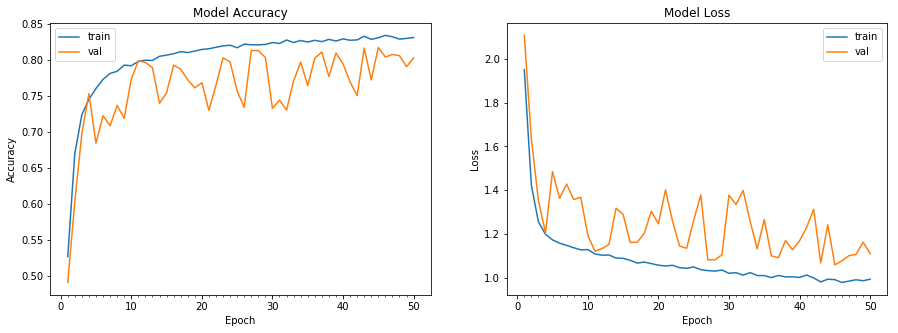

Accuracy on test data is: 81.69


In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

checkpointer = ModelCheckpoint(filepath='assignment6_model_B.h5', verbose = 1, save_best_only=True, monitor='val_acc', mode='max')


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[checkpointer])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
# Load the weights with the best validation accuracy:
model.load_weights('assignment6_model_B.h5')
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))